In [1]:
import aienvs
import aiagents
from aiagents.single.QAgent import QAgent
from aienvs.gym.DecoratedSpace import DecoratedSpace
import random
from aienvs.GroupingRobots.GroupingRobots import GroupingRobots
from aiagents.multi.BasicComplexAgent import BasicComplexAgent
from aienvs.gym.PackedSpace import PackedSpace
from aienvs.gym.ModifiedGymEnv import ModifiedGymEnv
from aienvs.runners.Episode import Episode
import time
import numpy as np
from aiagents.utils.Hashed import Hashed

In [2]:
env_parameters = {
    'robots':[ 
        {'id': "robot1", 'pos':'random'}, 
        {'id': "robot2", 'pos':'random'},
        {'id': "robot3", 'pos':'random'},
    ],
    'steps':3,
    'map':['...',
           '...',
           '...'],
    'doneOnFirstGrouping': True
}
q_agent_parameters = {
    'alpha':0.1, 
    'gamma':1, 
    'epsilon': 0.1
}

In [3]:
def build_up_individual_q_learning_env():
    env = GroupingRobots(env_parameters)
    return env

In [4]:
def build_up_centralized_q_learning_env():
    original_env = GroupingRobots(env_parameters)
    list_of_agents = list(original_env.action_space.spaces.keys())
    packed_action_space = PackedSpace(original_env.action_space, {"joint":list_of_agents})
    centralized_env = ModifiedGymEnv(original_env, packed_action_space)
    return centralized_env

In [5]:
def evaluate_centralized_q_learning(centralized_q_agent, num_episodes=1, render=False):
    env = build_up_centralized_q_learning_env()
    centralized_q_agent.eval()
    returns = []
    for i in range(num_episodes):
        initial_obs = env.reset()
        if render is True:
            env.render()
        epsisode = Episode(centralized_q_agent, env, initialObs=initial_obs, render=render, doneStep=True)
        steps, totalRewards = epsisode.run()
        returns.append(totalRewards)
    return returns

In [6]:
def evaluate_individual_q_learning(q_agents, num_episodes=1, render=False):
    env = build_up_individual_q_learning_env()
    for q_agent in q_agents:
        q_agent.eval()
    agent_component = BasicComplexAgent(q_agents, env.action_space, env.observation_space)
    returns = []
    for i in range(num_episodes):
        initial_obs = env.reset()
        if render is True:
            env.render()
        epsisode = Episode(agent_component, env, initialObs=initial_obs, render=render, doneStep=True)
        steps, totalRewards = epsisode.run()
        returns.append(totalRewards)
    return returns

In [7]:
def individual_q_learning(num_episodes, eval_freq=1, num_eval_episodes=1):
    env = build_up_individual_q_learning_env()
    list_of_agents = list(env.action_space.spaces.keys())
    q_agents = []
    for agentID in list_of_agents:
        q_agents.append(QAgent(agentID, env.action_space[agentID], env.observation_space, parameters=q_agent_parameters))
    agent_component = BasicComplexAgent(q_agents, env.action_space, env.observation_space)
    test_returns = []
    test_stds = []
    for i in range(num_episodes):
        initial_obs = env.reset()
        for q_agent in q_agents:
            q_agent.train()
        epsisode = Episode(agent_component, env, initialObs=initial_obs, render=False, doneStep=True)
        steps, totalRewards = epsisode.run()
        if i % eval_freq == 0:
            for q_agent in q_agents:
                q_agent.eval()
            returns = evaluate_individual_q_learning(q_agents, num_eval_episodes, False)
            test_returns.append(np.mean(returns))
            test_stds.append(np.std(returns))
    return q_agents, test_returns, test_stds

In [8]:
def centralized_q_learning(num_episodes, eval_freq=1, num_eval_episodes=1):
    env = build_up_centralized_q_learning_env()
    test_returns = []
    test_stds = []
    centralized_q_agent = QAgent("joint", env.action_space.get("joint"), env.observation_space, parameters=q_agent_parameters)
    for i in range(num_episodes):
        initial_obs = env.reset()
        centralized_q_agent.train()
        epsisode = Episode(centralized_q_agent, env, initialObs=initial_obs, render=False, doneStep=True)
        steps, totalRewards = epsisode.run()
        if i % eval_freq == 0:
            returns = evaluate_centralized_q_learning(centralized_q_agent, num_eval_episodes, False)
            test_returns.append(np.mean(returns))
            test_stds.append(np.std(returns))
    return centralized_q_agent, test_returns, test_stds

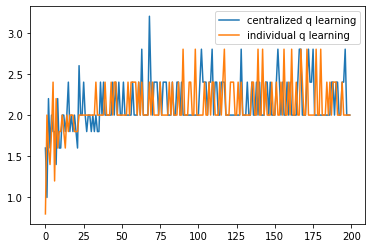

In [31]:
import matplotlib.pyplot as plt

centralized_q_agent, test_returns, test_stds = centralized_q_learning(10000, 50, 10)
plt.plot(test_returns, label="centralized q learning")

individual_q_agents, test_returns, test_stds = individual_q_learning(10000, 50, 10)
plt.plot(test_returns, label="individual q learning")

plt.legend()

In [49]:
evaluate_centralized_q_learning(centralized_q_agent, num_episodes=1, render=True)

R..
..R
R..

.RR
...
.R.

.R.
...
..R



[2]